In [95]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import operator
from math import floor,ceil
import tensorflow as tf
print(tf.__version__)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2.1.0


Using TensorFlow backend.


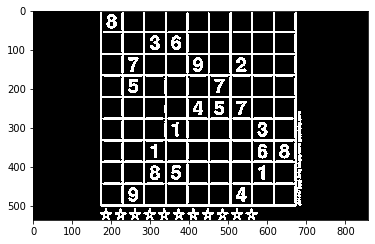

In [32]:
def proc_img(img):
    img1 = cv.GaussianBlur(img.copy(), (9, 9), 0)
    img1 = cv.adaptiveThreshold(img1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    img1 = cv.bitwise_not(img1, img1)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    img1 = cv.dilate(img1, kernel)
    return img1

img = cv.imread('sudoku2.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
plt.imshow(processed,'gray')

In [33]:
def show_img(img):
	cv.imshow('image', img)
	cv.waitKey(0)
	cv.destroyAllWindows()

In [34]:
def display_points(img, points, radius=5, colour=(0, 0, 255)):
    img = img.copy()
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    for point in points:
        img = cv.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_img(img)

In [35]:
def grid(img):
    contours, _ = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    cnt = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    return [cnt[top_left][0], cnt[top_right][0], cnt[bottom_right][0], cnt[bottom_left][0]]

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
print(corners)
display_points(processed, corners)

[array([ 46, 143], dtype=int32), array([381, 146], dtype=int32), array([380, 478], dtype=int32), array([ 44, 478], dtype=int32)]


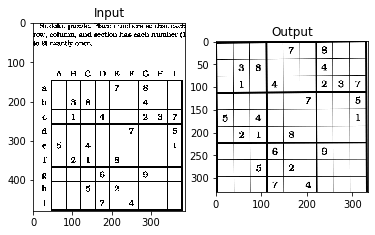

In [135]:
def perspect(img,corners):
    rows,cols = img.shape
    h = corners[1][0] - corners[0][0]
    w = corners[2][1] - corners[1][1]
    pts1 = np.float32([corners[0],corners[1],corners[3],corners[2]])
    #pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    dst = cv.warpPerspective(img,M,(h,w))
    show_img(dst)
    plt.subplot(121),plt.imshow(img,'gray'),plt.title('Input')
    plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')
    return dst

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)

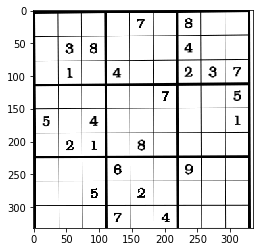

In [136]:
plt.imshow(img_final,'gray')

(<matplotlib.axes._subplots.AxesSubplot at 0x7fead0ba4390>,
 Text(0.5, 1.0, 'Output'))

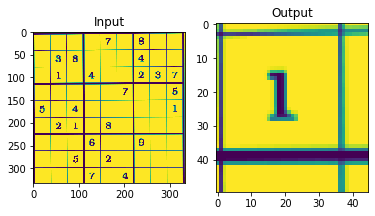

In [137]:
rowp = row/9
colp = col/9
i=1
j=2
pts1 = np.float32([[i*rowp,j*rowp],[(i+1)*rowp,j*colp],[i*rowp,(j+1)*colp],[(i+1)*rowp,(j+1)*colp]])
#pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
pts2 = np.float32([[0,0],[rowp,0],[0,colp],[rowp,colp]])
M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img_final,M,(45,50))
plt.subplot(121),plt.imshow(img_final,'gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')

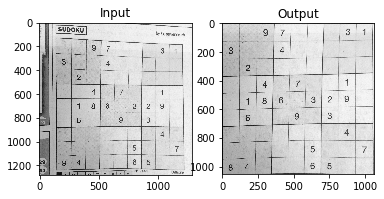

In [92]:
def extract_grid(img):
    row, col = img.shape
    rowp = row/9
    colp = col/9
    imgp = []
    dim = (floor(rowp),floor(colp))
    for i in range(9):
        for j in range(9):
            pts1 = np.float32([[i*rowp,j*rowp],[(i+1)*rowp,j*colp],[i*rowp,(j+1)*colp],[(i+1)*rowp,(j+1)*colp]])
            pts2 = np.float32([[0,0],[rowp,0],[0,colp],[rowp,colp]])
            M = cv.getPerspectiveTransform(pts1,pts2)
            dst = cv.warpPerspective(img,M,dim)
            imgp.append(dst)
    return imgp

img = cv.imread('sudoku3.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)

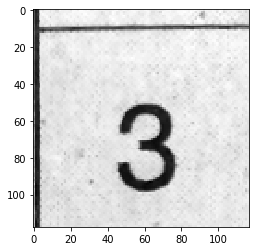

In [118]:
plt.imshow(imgp[1],'gray')

In [103]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print(x_train[1].shape)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train[1].shape)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

(28, 28)
(28, 28, 1)


In [97]:
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

In [98]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 18s 306us/step - loss: 0.2051 - accuracy: 0.9387
Epoch 2/10
60000/60000 [==============================] - 17s 282us/step - loss: 0.0809 - accuracy: 0.9760
Epoch 3/10
60000/60000 [==============================] - 17s 282us/step - loss: 0.0551 - accuracy: 0.9823
Epoch 4/10
60000/60000 [==============================] - 17s 284us/step - loss: 0.0427 - accuracy: 0.9863
Epoch 5/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.0339 - accuracy: 0.9885
Epoch 6/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.0279 - accuracy: 0.9909
Epoch 7/10
60000/60000 [==============================] - 18s 293us/step - loss: 0.0229 - accuracy: 0.9920
Epoch 8/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.0206 - accuracy: 0.9930
Epoch 9/10
60000/60000 [==============================] - 17s 291us/step - loss: 0.0188 - accuracy: 0.9934
Epoch 10/10
60000/60000 [============

(118, 117)
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


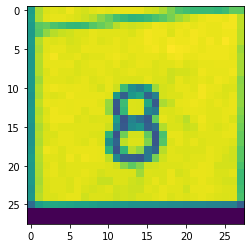

In [130]:
temp = np.array(imgp)
print(temp[3].shape)
temp1 = cv.resize(temp[8], (28,28), interpolation = cv.INTER_AREA) 
plt.imshow(temp1)
temp1 = temp1.reshape(1,28, 28, 1)
print(model.predict(np.array(temp1)))